In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Merging Datasets

### Play Store

In [2]:
play_features = pd.read_csv("data/play_features_0317.csv")
play_labeled = pd.read_csv("data/p01_apps_play_0202.csv")
play_labeled_p01 = play_labeled.drop(columns=['Pillar1', 'Pillar2', 'Coded 4 Pillars', 'Coded_MM_Thesis', 'Sumscore_abuse', 'Coded_Abuses'])

In [3]:
play_labeled_p01['Educational'].value_counts()

0.0    202
1.0     54
Name: Educational, dtype: int64

In [4]:
play_full = play_labeled_p01.merge(play_features, left_on="app_fullname", right_on="appId", how="inner")

In [5]:
play_full.head()

,app_fullname,app_title,Violent,Educational,Manipulative_3plus,Manipulative_2plus,reviews,offersIAP,ratings,containsAds,...,ratingsStd,ratingsSkew,descriptionSentiment,reviewsSentiment,descriptionReadability,descriptionGrammar,developerNApps,developerAppAgeMedian,developerCountry,releasedYear
0,air.com.bmapps.gossipgirlsdivasinhighschool,Gossip Girl Divas in Highschool,0.0,0.0,NaN,NaN,201,True,15628,True,...,1.6567,-0.8693,0.9975,0.1468,10.5,99.64,20,5.8,RO,2018.0
1,air.com.bmapps.injureddolphincare,Injured Dolphin Care,0.0,0.0,NaN,NaN,38,False,970,True,...,1.3717,-1.6678,0.9972,0.3987,10.9,99.52,20,5.8,RO,2016.0
2,air.com.foxandsheep.chomp,CHOMP by Christoph Niemann,0.0,0.0,NaN,NaN,834,True,12805,False,...,1.1934,-2.0648,0.9988,0.7526,7.8,99.79,10,5.3,DE,2016.0
3,air.com.hypah.io.slither,slither.io,1.0,0.0,0.0,1.0,312663,True,6718599,True,...,1.5290,-1.1150,0.8807,0.5406,4.2,99.77,1,7.0,US,2016.0
4,air.com.pixelstudio8.venom.angry.crash.rush.io...,Venom Angry Crashy Rush Online,1.0,0.0,NaN,NaN,9767,False,290506,True,...,1.4253,-1.5238,-0.8942,0.4278,5.7,99.92,1,5.9,Unlisted,2017.0


In [6]:
play_full.shape

(283, 30)

In [7]:
play_full['releasedYears'] = 2023 - play_full['releasedYear']

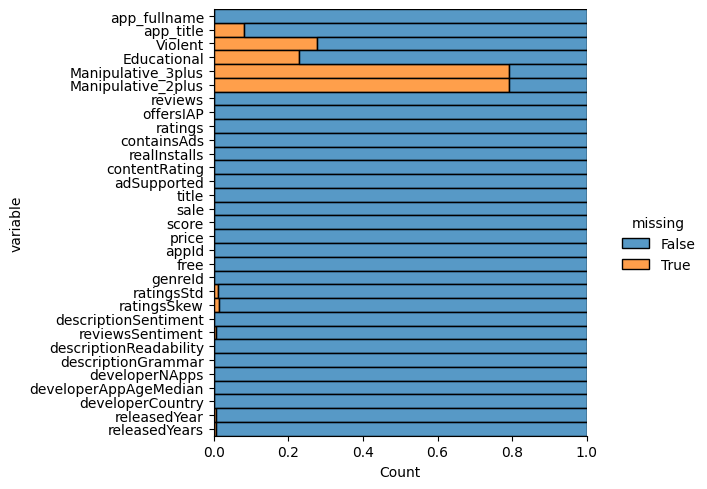

In [8]:
sns.displot(
    data=play_full.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

## Educational

### Preprocessing

In [9]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [10]:
play_educational = play_full.dropna(subset=['ratingsStd', 'ratingsSkew', 'releasedYear', 'releasedYears', 'Educational']).drop(columns=['app_fullname', 'app_title', 'title', 'Violent', 'Manipulative_3plus', 'Manipulative_2plus', 'releasedYear'])

In [11]:
play_educational.shape

(214, 24)

In [12]:
X = play_educational.drop(columns=['Educational', 'appId', 'developerCountry'])
y = play_educational['Educational']

In [13]:
y.value_counts()

0.0    173
1.0     41
Name: Educational, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
num_columns = ['realInstalls', 'price', 'ratings', 'reviews', 'score', 'ratingsStd', 'ratingsSkew', 'descriptionSentiment', 'reviewsSentiment', 'descriptionReadability', 'descriptionGrammar', 'developerNApps', 'developerAppAgeMedian', 'releasedYears']
cat_columns = ['genreId', 'contentRating'] # , 'developerCountry'
bool_columns = ['offersIAP', 'sale', 'containsAds', 'free', 'adSupported']

In [16]:
scaler = StandardScaler()
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_test[num_columns] = scaler.fit_transform(X_test[num_columns])

In [17]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [18]:
X_train, X_test = X_train.align(X_test, axis=1, fill_value=0)

In [19]:
sm = SMOTE(random_state=42)

In [20]:
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

### Modeling

In [140]:
lr_e = LogisticRegression(class_weight="balanced")
dt_e = DecisionTreeClassifier(class_weight="balanced")
rf_e = RandomForestClassifier(class_weight="balanced", random_state=123)
xgb_e = XGBClassifier(scale_pos_weight=y.value_counts()[0]/y.value_counts()[1])
svm_e = SVC(class_weight="balanced")

In [32]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [33]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [143]:
lr_e_score = cross_validate(lr_e, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True, return_estimator=True)
dt_e_score = cross_validate(dt_e, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True, return_estimator=True)
rf_e_score = cross_validate(rf_e, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True, return_estimator=True)
xgb_e_score = cross_validate(xgb_e, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True, return_estimator=True)
svm_e_score = cross_validate(svm_e, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True, return_estimator=True)

In [144]:
print('Model Scores (train_behavior)')
pd.DataFrame({'Model': ['LR', 'DT', 'RF', 'XGB', 'SVM'], 'Accuracy': [lr_e_score['test_accuracy'].mean(), dt_e_score['test_accuracy'].mean(), rf_e_score['test_accuracy'].mean(), xgb_e_score['test_accuracy'].mean(), svm_e_score['test_accuracy'].mean()], 'Recall': [lr_e_score['test_recall'].mean(), dt_e_score['test_recall'].mean(), rf_e_score['test_recall'].mean(), xgb_e_score['test_recall'].mean(), svm_e_score['test_recall'].mean()], 'Precision': [lr_e_score['test_precision'].mean(), dt_e_score['test_precision'].mean(), rf_e_score['test_precision'].mean(), xgb_e_score['test_precision'].mean(), svm_e_score['test_precision'].mean()], 'F1': [lr_e_score['test_f1'].mean(), dt_e_score['test_f1'].mean(), rf_e_score['test_f1'].mean(), xgb_e_score['test_f1'].mean(), svm_e_score['test_f1'].mean(), ]}).sort_values('F1', ascending=False)

Model Scores (train_behavior)


,Model,Accuracy,Recall,Precision,F1
2,RF,0.899172,0.913866,0.890711,0.901582
3,XGB,0.859783,0.906933,0.831533,0.866544
1,DT,0.801967,0.827311,0.790727,0.807908
4,SVM,0.798706,0.834034,0.784926,0.804447
0,LR,0.762681,0.791597,0.753572,0.770531


In [145]:
rf_e.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [165]:
# testing feature importance for logistic regression
for idx,estimator in enumerate(rf_e_score['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(rf_e.feature_importances_[idx],
                                       index = X_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
                            importance
adSupported                   0.004573
price                         0.004573
genreId_GAME_RACING           0.004573
genreId_GAME_ROLE_PLAYING     0.004573
genreId_GAME_SIMULATION       0.004573
genreId_GAME_SPORTS           0.004573
genreId_GAME_STRATEGY         0.004573
genreId_MUSIC_AND_AUDIO       0.004573
offersIAP                     0.004573
ratings                       0.004573
containsAds                   0.004573
ratingsSkew                   0.004573
ratingsStd                    0.004573
realInstalls                  0.004573
releasedYears                 0.004573
reviews                       0.004573
reviewsSentiment              0.004573
sale                          0.004573
genreId_GAME_PUZZLE           0.004573
genreId_GAME_MUSIC            0.004573
genreId_GAME_EDUCATIONAL      0.004573
genreId_GAME_CASUAL           0.004573
contentRating_Everyone 10+    0.004573
contentRating_Ma

In [151]:
param_rf = { 
    'n_estimators': [50, 100, 150, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [6, 8, 10, 20],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 5, 10]
}

In [152]:
grid_rf = GridSearchCV(estimator=rf_e, 
                        param_grid=param_rf,
                        cv=skf,
                        scoring='f1', 
                        verbose=1).fit(X_train_res, y_train_res)

Fitting 4 folds for each of 384 candidates, totalling 1536 fits


In [153]:
print(f'rf: {grid_rf.best_params_}')

rf: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [154]:
rf_e_2 = RandomForestClassifier(**grid_rf.best_params_, class_weight="balanced", random_state=123)

In [155]:
rf_e_score_2 = cross_validate(rf_e_2, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True)

In [166]:
print(f"Accuracy: {rf_e_score_2['test_accuracy'].mean()}")
print(f"Recall: {rf_e_score_2['test_recall'].mean()}")
print(f"Precision: {rf_e_score_2['test_precision'].mean()}")
print(f"F1: {rf_e_score_2['test_f1'].mean()}")

Accuracy: 0.920807453416149
Recall: 0.9285714285714285
Precision: 0.9173927465723132
F1: 0.9224736946595196


In [167]:
from joblib import dump
dump(rf_e_2, 'models/rf_e_0402.joblib')

['models/rf_e_0402.joblib']

### Testing

In [157]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [158]:
rf_e_2.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=50,
                       random_state=123)

In [159]:
y_pred = rf_e_2.predict(X_test)

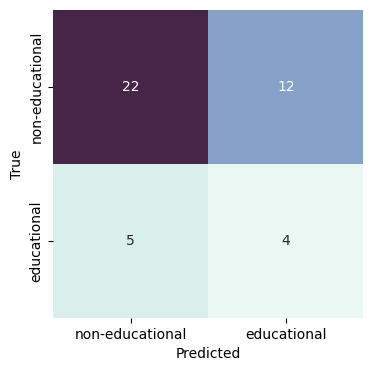

In [160]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
ax = sns.heatmap(cm, annot=True, fmt='g', cmap=sns.cubehelix_palette(start=.7, rot=-.5, light=0.95, dark=0.2, as_cmap=True), cbar=False)
ax.set_xlabel('Predicted'); ax.set_ylabel('True');
ax.xaxis.set_ticklabels(['non-educational', 'educational']); ax.yaxis.set_ticklabels(['non-educational', 'educational']);

In [161]:
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("F1: " + str(f1_score(y_test, y_pred)))

Accuracy: 0.6046511627906976
F1: 0.32


## Violent

### Preprocessing

In [21]:
play_violent = play_full.dropna(subset=['ratingsStd', 'ratingsSkew', 'releasedYear', 'releasedYears', 'Violent']).drop(columns=['app_fullname', 'app_title', 'title', 'Educational', 'Manipulative_3plus', 'Manipulative_2plus', 'releasedYear'])

In [22]:
play_violent.shape

(202, 24)

In [23]:
X = play_violent.drop(columns=['Violent', 'appId', 'developerCountry'])
y = play_violent['Violent']

In [24]:
y.value_counts()

0.0    125
1.0     77
Name: Violent, dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
scaler = StandardScaler()
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])

In [27]:
X_train = pd.get_dummies(X_train, drop_first=True)

In [28]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

### Modeling

In [30]:
lr_v = LogisticRegression(class_weight="balanced")
dt_v = DecisionTreeClassifier(class_weight="balanced")
rf_v = RandomForestClassifier(class_weight="balanced", random_state=123)
xgb_v = XGBClassifier(scale_pos_weight=y.value_counts()[0]/y.value_counts()[1])
svm_v = SVC(class_weight="balanced")

In [34]:
lr_v_score = cross_validate(lr_v, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True, return_estimator=True)
dt_v_score = cross_validate(dt_v, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True, return_estimator=True)
rf_v_score = cross_validate(rf_v, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True, return_estimator=True)
xgb_v_score = cross_validate(xgb_v, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True, return_estimator=True)
svm_v_score = cross_validate(svm_v, X_train_res, y_train_res, cv=skf, scoring=["accuracy", "recall", "precision", "f1"], return_train_score=True, return_estimator=True)

In [35]:
print('Model Scores (train_behavior)')
pd.DataFrame({'Model': ['LR', 'DT', 'RF', 'XGB', 'SVM'], 'Accuracy': [lr_v_score['test_accuracy'].mean(), dt_v_score['test_accuracy'].mean(), rf_v_score['test_accuracy'].mean(), xgb_v_score['test_accuracy'].mean(), svm_v_score['test_accuracy'].mean()], 'Recall': [lr_v_score['test_recall'].mean(), dt_v_score['test_recall'].mean(), rf_v_score['test_recall'].mean(), xgb_v_score['test_recall'].mean(), svm_v_score['test_recall'].mean()], 'Precision': [lr_v_score['test_precision'].mean(), dt_v_score['test_precision'].mean(), rf_v_score['test_precision'].mean(), xgb_v_score['test_precision'].mean(), svm_v_score['test_precision'].mean()], 'F1': [lr_v_score['test_f1'].mean(), dt_v_score['test_f1'].mean(), rf_v_score['test_f1'].mean(), xgb_v_score['test_f1'].mean(), svm_v_score['test_f1'].mean(), ]}).sort_values('F1', ascending=False)

Model Scores (train_behavior)


,Model,Accuracy,Recall,Precision,F1
2,RF,0.821429,0.887917,0.783776,0.832168
0,LR,0.806122,0.805833,0.807199,0.805833
3,XGB,0.780612,0.827500,0.755549,0.789267
4,SVM,0.775510,0.765833,0.789551,0.772195
1,DT,0.714286,0.735417,0.711431,0.721395
